In [10]:
import os
import numpy as np
import pandas as pd
import torch
import random
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.all import *
from PIL import Image  
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.metrics import accuracy
from fastai.callback.all import SaveModelCallback, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
class LiverMRIDataset(Dataset):
    def __init__(self, dataframe, image_column_name, label_column_name, transform=None):
        self.dataframe = dataframe
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe[self.image_column_name].iloc[idx]
        label = self.dataframe[self.label_column_name].iloc[idx]

        # Load the grayscale image
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        # Convert grayscale to 3 channels
        transform_to_3_channel = transforms.Compose([
            transforms.Grayscale(num_output_channels=3)
        ])
        image = transform_to_3_channel(image)

        # Apply other transformations if specified
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label




class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        return x


class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet50(pretrained=False)
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])  # Use the first 9 layers of ResNet50

    def forward(self, x):
        return self.backbone(x)


class LiverDiseaseModel:
    def __init__(self, train_dataframe_path, test_dataframe_path, image_column_name, label_column_name, split_ratio=0.8, batch_size=8, model_name='resnet_liver_model'):
        self.train_dataframe_path = train_dataframe_path
        self.test_dataframe_path = test_dataframe_path
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name
        self.split_ratio = split_ratio
        self.batch_size = batch_size
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load the training and testing datasets
        self.train_df = pd.read_csv(self.train_dataframe_path)
        self.test_df = pd.read_csv(self.test_dataframe_path)

        # Prepare the training and validation datasets
        self.train_transforms = self._get_transforms(train=True)
        self.valid_transforms = self._get_transforms(train=False)

        train_size = int(len(self.train_df) * self.split_ratio)
        valid_size = len(self.train_df) - train_size
        train_subset, valid_subset = random_split(self.train_df, [train_size, valid_size])

        self.train_dataset = LiverMRIDataset(train_subset.dataset, self.image_column_name, self.label_column_name, transform=self.train_transforms)
        self.valid_dataset = LiverMRIDataset(valid_subset.dataset, self.image_column_name, self.label_column_name, transform=self.valid_transforms)
        self.test_dataset = LiverMRIDataset(self.test_df, self.image_column_name, self.label_column_name, transform=self.valid_transforms)

        self.dls = DataLoaders.from_dsets(
            self.train_dataset,
            self.valid_dataset,
            bs=self.batch_size,
            num_workers=4,
            device=self.device
        )

    def _get_transforms(self, train=True):
        if train:
            return transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            return transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def _prepare_model(self):
        backbone = Backbone()
        classifier = Classifier(num_classes=2)
        backbone.load_state_dict(torch.load('models/ResNet50.pt'))
        model = nn.Sequential(backbone, classifier)
        return model

    def train(self, base_lr=1e-5, epochs=10):
        model = self._prepare_model()

        learn = Learner(
            self.dls,
            model,
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy],
            cbs=[
                SaveModelCallback(fname=self.model_name, monitor='valid_loss'),
                EarlyStoppingCallback(monitor='valid_loss', patience=10)
            ]
        ).to_fp16()

        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
            learn.model = torch.nn.DataParallel(learn.model)

        learn.fine_tune(epochs, base_lr=base_lr)

        learn.save(f"{self.model_name}_best_model")
        self.learn = learn  # Save the learner for evaluation

    def evaluate_validation_set(self):
        preds, targs = self.learn.get_preds(dl=self.learn.dls.valid)
        self._print_classification_report(targs, preds)
        self._plot_confusion_matrix(targs, preds)

    def evaluate_test_set(self):
        test_dl = DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)
        dls = DataLoaders(test_dl, device=self.device)
        model = self._prepare_model()
        learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
        learn.load(f"{self.model_name}_best_model")

        print("\nEvaluating on test data:")
        preds, targs = learn.get_preds(dl=test_dl)
        self._print_classification_report(targs, preds)
        self._plot_confusion_matrix(targs, preds)

    def _print_classification_report(self, targs, preds):
        report = classification_report(targs.cpu(), preds.argmax(dim=1).cpu(), target_names=['No CAD', 'CAD'])
        print(report)

    def _plot_confusion_matrix(self, targs, preds):
        cm = confusion_matrix(targs.cpu(), preds.argmax(dim=1).cpu())
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CAD', 'CAD'], yticklabels=['No CAD', 'CAD'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using 3 GPUs


/tmp/ipykernel_3387969/3363481141.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone.load_state_dict(torch.load('models/ResNet50.pt'))
/work/07880/devansh/anacon

epoch,train_loss,valid_loss,accuracy,time
0,0.711863,0.683217,0.578881,03:13


Better model found at epoch 0 with valid_loss value: 0.6832167506217957.


/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locat

epoch,train_loss,valid_loss,accuracy,time
0,0.697720,0.681282,0.586135,02:44
1,0.701541,0.679927,0.592814,02:43
2,0.696560,0.676783,0.596614,02:47
3,0.683964,0.676168,0.614233,02:53
4,0.678955,0.670625,0.618954,02:54
5,0.680473,0.666618,0.626439,02:54
6,0.684125,0.663721,0.618148,02:54
7,0.683057,0.659447,0.631391,02:54
8,0.678340,0.653691,0.631621,02:53
9,0.672079,0.646813,0.630240,02:52


Better model found at epoch 0 with valid_loss value: 0.6812818050384521.
Better model found at epoch 1 with valid_loss value: 0.6799273490905762.
Better model found at epoch 2 with valid_loss value: 0.6767831444740295.
Better model found at epoch 3 with valid_loss value: 0.6761682629585266.
Better model found at epoch 4 with valid_loss value: 0.6706245541572571.
Better model found at epoch 5 with valid_loss value: 0.6666176915168762.
Better model found at epoch 6 with valid_loss value: 0.663720965385437.
Better model found at epoch 7 with valid_loss value: 0.6594467759132385.
Better model found at epoch 8 with valid_loss value: 0.6536905765533447.
Better model found at epoch 9 with valid_loss value: 0.6468133926391602.
Better model found at epoch 11 with valid_loss value: 0.6445097923278809.
Better model found at epoch 12 with valid_loss value: 0.6417512893676758.
Better model found at epoch 13 with valid_loss value: 0.6389968991279602.
Better model found at epoch 14 with valid_loss va

              precision    recall  f1-score   support

      No CAD       0.65      0.66      0.65      4342
         CAD       0.65      0.65      0.65      4342

    accuracy                           0.65      8684
   macro avg       0.65      0.65      0.65      8684
weighted avg       0.65      0.65      0.65      8684



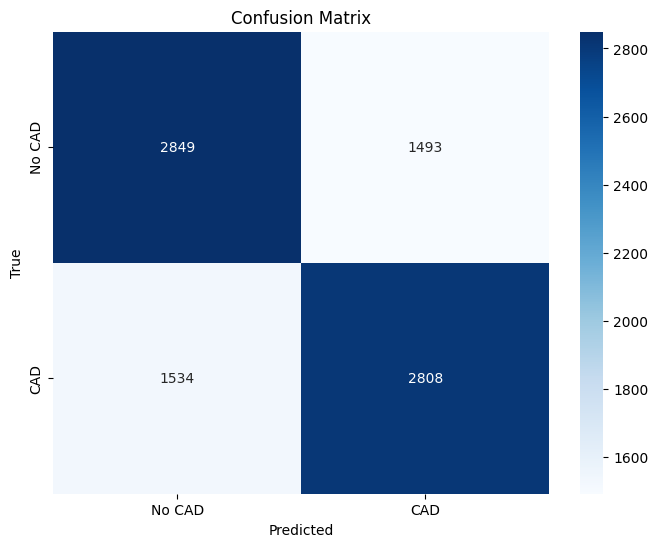


Test Set Evaluation:


/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3387969/3363481141.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value fo


Evaluating on test data:


/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/fastai/callback/fp16.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/fastai/callback/fp16.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


              precision    recall  f1-score   support

      No CAD       0.61      0.70      0.65       200
         CAD       0.65      0.55      0.60       200

    accuracy                           0.63       400
   macro avg       0.63      0.63      0.63       400
weighted avg       0.63      0.63      0.63       400



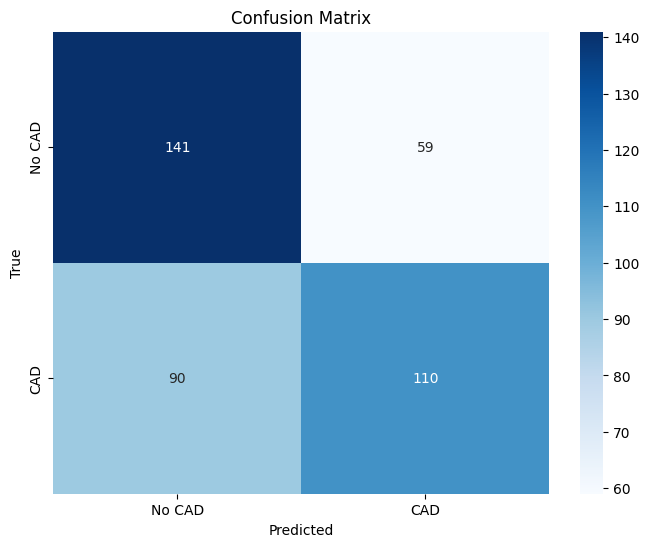

In [12]:
if __name__ == "__main__":
    model = LiverDiseaseModel(
        train_dataframe_path='Final_Datasets/train_resnet_liver.csv',
        test_dataframe_path='Final_Datasets/test_data_incidence.csv',
        image_column_name='FilePath_liver',
        label_column_name='CAD',
        split_ratio=0.85,  # Use 80% for training and 20% for validation
        model_name='liver_mri_radIM_resnet50_model_nov'
    )

    # Train the model
    model.train(epochs=25, base_lr=1e-5)

    # Evaluate on validation set
    print("\nValidation Set Evaluation:")
    model.evaluate_validation_set()

    # Evaluate on test set
    print("\nTest Set Evaluation:")
    model.evaluate_test_set()


Loading best model from liver_mri_custom_resnet50_model_fold_3_best_model


/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Evaluating on test data:


              precision    recall  f1-score   support

      No CAD       0.55      0.66      0.60       200
         CAD       0.57      0.45      0.50       200

    accuracy                           0.56       400
   macro avg       0.56      0.56      0.55       400
weighted avg       0.56      0.56      0.55       400



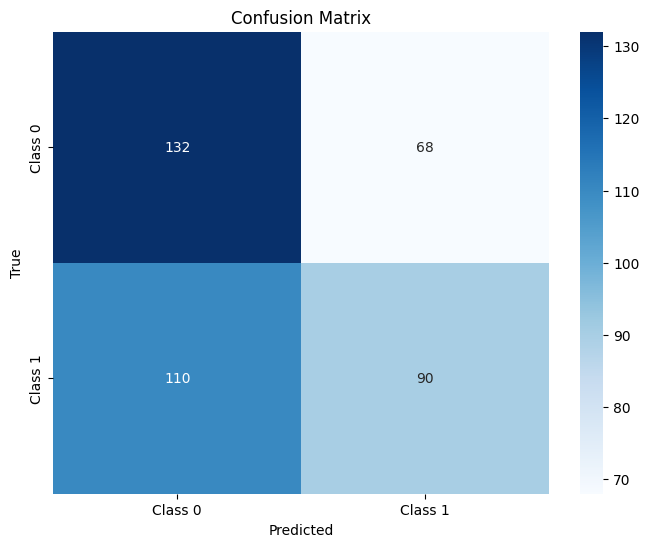

In [11]:
model.evaluate_test_set()

In [ ]:
# Dataset Class for Liver MRI Data
class LiverMRIDataset(Dataset):
    def __init__(self, dataframe, image_column_name, label_column_name, transform=None):
        self.dataframe = dataframe
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe[self.image_column_name].iloc[idx]
        label = self.dataframe[self.label_column_name].iloc[idx]

        # Load the image
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label


# Custom Backbone and Classifier for Liver Disease Model
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        return x


class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet50(pretrained=False)
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])  # Load the first 9 layers of ResNet50

    def forward(self, x):
        return self.backbone(x)


# Model class adapted for liver MRI dataset
class LiverDiseaseModel:
    def __init__(self, dataframe_path, image_column_name, label_column_name, test_dataframe_path=None, split_ratio=0.90, batch_size=8, model_name='resnet_liver_model'):
        self.dataframe_path = dataframe_path
        self.test_dataframe_path = test_dataframe_path
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name
        self.split_ratio = split_ratio
        self.batch_size = batch_size
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._prepare_data()
        self._prepare_model()

    def _prepare_data(self):
        df = pd.read_csv(self.dataframe_path)

        # Check if 'split' column exists in the CSV
        if 'split' in df.columns:
            train_df = df[df['split'] == 'train']
            valid_df = df[df['split'] == 'valid']
        else:
            # Perform train/validation split based on the split_ratio parameter
            train_df = df.sample(frac=self.split_ratio, random_state=42)
            valid_df = df.drop(train_df.index)

        # Define data augmentations and normalization
        train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
        ])

        valid_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create datasets with transforms
        train_dataset = LiverMRIDataset(train_df, self.image_column_name, self.label_column_name, transform=train_transforms)
        valid_dataset = LiverMRIDataset(valid_df, self.image_column_name, self.label_column_name, transform=valid_transforms)

        # Create DataLoaders
        self.dls = DataLoaders.from_dsets(
            train_dataset,
            valid_dataset,
            bs=self.batch_size,
            num_workers=4,
            device=self.device
        )

        # Prepare test dataset if provided
        if self.test_dataframe_path:
            test_df = pd.read_csv(self.test_dataframe_path)
            self.test_dataset = LiverMRIDataset(
                test_df,
                self.image_column_name, self.label_column_name,
                transform=valid_transforms  # Use the same transforms as validation for test set
            )
        else:
            self.test_dataset = None

    def _prepare_model(self):
        # Load the custom ResNet50 backbone and classifier
        backbone = Backbone()
        classifier = Classifier(num_classes=2)  # 2 output classes for binary classification

        # Load pretrained weights from custom model (replace 'resnet50.pth' with your path)
        backbone.load_state_dict(torch.load('models/ResNet50.pt'))

        # Combine backbone and classifier into a single model
        model = nn.Sequential(backbone, classifier)

        # Use Fastai's `Learner` class
        self.learn = Learner(
            self.dls,
            model,
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy],
            cbs=[
                SaveModelCallback(fname=self.model_name, monitor='valid_loss'),
                EarlyStoppingCallback(monitor='valid_loss', patience=10)
            ]
        ).to_fp16()

        # Use multiple GPUs if available
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
            self.learn.model = torch.nn.DataParallel(self.learn.model)

    def fine_tune_model(self, base_lr=1e-5, epochs=10):
        self.learn.fine_tune(epochs, base_lr=base_lr)

    def evaluate(self):
        print("Evaluating on validation data:")
        preds, targs = self.learn.get_preds()
        self._print_classification_report(targs, preds)
        self._plot_confusion_matrix(targs, preds)

        # Evaluate on test data if available
        if self.test_dataset:
            print("\nEvaluating on test data:")
            test_dl = self.dls.test_dl(self.test_dataset)
            test_preds, test_targs = self.learn.get_preds(dl=test_dl)
            self._print_classification_report(test_targs, test_preds)
            self._plot_confusion_matrix(test_targs, test_preds)

    def _print_classification_report(self, targs, preds):
        report = classification_report(targs.cpu(), preds.argmax(dim=1).cpu(), target_names=['Class 0', 'Class 1'])
        print(report)

    def _plot_confusion_matrix(self, targs, preds):
        cm = confusion_matrix(targs.cpu(), preds.argmax(dim=1).cpu())
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

In [ ]:
if __name__ == "__main__":
    model = LiverDiseaseModel(
        dataframe_path='Final_Datasets/train_resnet_liver.csv', 
        test_dataframe_path='Final_Datasets/test_data_incidence.csv', 
        image_column_name='FilePath_liver',  # Specify the image column name
        label_column_name='CAD',  # Specify the label column name
        model_name='liver_mri_custom_resnet50_model'
    )
    model.fine_tune_model(epochs=50, base_lr=1e-6)
    model.evaluate()

In [ ]:
# class NPYDataset(Dataset):
#     def __init__(self, dataframe, image_column, label_column, first_slice_only=True):
#         self.dataframe = dataframe
#         self.image_column = image_column
#         self.label_column = label_column
#         self.first_slice_only = first_slice_only
#         self.transform = transforms.Compose([
#             transforms.Lambda(lambda x: np.stack([x, x, x], axis=0) if x.ndim == 2 else x),
#             transforms.Lambda(lambda x: x.transpose(1, 2, 0)),
#             transforms.Lambda(lambda x: x.astype(np.float32)),
#             transforms.ToPILImage(),
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#         ])

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         npy_path = self.dataframe.iloc[idx][self.image_column]
#         label = self.dataframe.iloc[idx][self.label_column]
        
#         if self.first_slice_only:
#             slice_image = np.load(npy_path)[:, :, :, 0][0]
#         else:
#             raise ValueError("Only first slice mode is currently supported.")

#         slice_image = self.transform(slice_image)
#         label = torch.tensor(label, dtype=torch.long)
        
#         return slice_image, label


# class Classifier(nn.Module):
#     def __init__(self, num_class):
#         super().__init__()
#         self.drop_out = nn.Dropout()
#         self.linear = nn.Linear(2048, num_class)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.drop_out(x)
#         x = self.linear(x)
#         return x


# class Backbone(nn.Module):
#     def __init__(self):
#         super().__init__()
#         base_model = models.resnet50(pretrained=False)
#         encoder_layers = list(base_model.children())
#         self.backbone = nn.Sequential(*encoder_layers[:9])

#     def forward(self, x):
#         return self.backbone(x)


# class HeartDiseaseModel:
#     def __init__(self, train_dataframe_path, test_dataframe_path=None, image_column='FilePath', label_column='CAD',
#                  batch_size=32, num_class=2, model_name='resnet_medical_model', seed=42):
#         self.train_dataframe_path = train_dataframe_path
#         self.test_dataframe_path = test_dataframe_path
#         self.image_column = image_column
#         self.label_column = label_column
#         self.batch_size = batch_size
#         self.model_name = model_name
#         self.seed = seed
#         self.num_class = num_class
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.best_model_path = f"{self.model_name}_best.pth"
#         self._load_data()

#     def _load_data(self):
#         self.df_train = pd.read_csv(self.train_dataframe_path)
#         if self.test_dataframe_path:
#             self.df_test = pd.read_csv(self.test_dataframe_path)

#     def _get_dataloaders(self, train_df, valid_df):
#         train_dataset = NPYDataset(train_df, image_column=self.image_column, label_column=self.label_column)
#         valid_dataset = NPYDataset(valid_df, image_column=self.image_column, label_column=self.label_column)

#         train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
#         valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
#         return train_loader, valid_loader

#     def _prepare_model(self):
#         # Load the pretrained backbone
#         backbone = Backbone()
#         backbone.load_state_dict(torch.load("/scratch/07880/devansh/CAD/Code_Analysis/models/ResNet50.pt"))  # Load pretrained medical weights
#         classifier = Classifier(num_class=self.num_class)
#         model = nn.Sequential(backbone, classifier)

#         # Use DataParallel for multi-GPU support
#         if torch.cuda.device_count() > 1:
#             print(f"Using {torch.cuda.device_count()} GPUs")
#             model = nn.DataParallel(model)

#         self.model = model.to(self.device)

#         # Optimizer and Loss function
#         self.criterion = nn.CrossEntropyLoss()
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

#     def train_model(self, train_loader, val_loader, num_epochs=10, fold_num=0):
#         min_valid_loss = np.inf

#         for e in range(num_epochs):
#             train_loss = 0.0
#             self.model.train()

#             for data, labels in train_loader:
#                 data, labels = data.to(self.device), labels.to(self.device)
#                 self.optimizer.zero_grad()
#                 output = self.model(data)
#                 loss = self.criterion(output, labels)
#                 loss.backward()
#                 self.optimizer.step()
#                 train_loss += loss.item()

#             # Validation
#             valid_loss = 0.0
#             all_preds, all_labels = [], []
#             self.model.eval()
#             with torch.no_grad():
#                 for data, labels in val_loader:
#                     data, labels = data.to(self.device), labels.to(self.device)
#                     output = self.model(data)
#                     loss = self.criterion(output, labels)
#                     valid_loss += loss.item()
                    
#                     # Collect predictions and labels for accuracy
#                     all_preds.append(output.argmax(dim=1).cpu().numpy())
#                     all_labels.append(labels.cpu().numpy())

#             # Compute validation accuracy
#             all_preds = np.concatenate(all_preds)
#             all_labels = np.concatenate(all_labels)
#             valid_accuracy = accuracy_score(all_labels, all_preds)

#             print(f'Epoch {e+1} | Training Loss: {train_loss/len(train_loader):.4f} | Validation Loss: {valid_loss/len(val_loader):.4f} | Validation Accuracy: {valid_accuracy:.4f}')

#             if min_valid_loss > valid_loss:
#                 print(f'Validation Loss Decreased ({min_valid_loss:.6f} -> {valid_loss:.6f}) | Saving Model')
#                 min_valid_loss = valid_loss
#                 torch.save(self.model.state_dict(), f'acl_fold{fold_num}_best_model.pth')

#     def cross_validate(self, n_splits=5, num_epochs=10):
#         kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
#         for fold, (train_idx, valid_idx) in enumerate(kf.split(self.df_train)):
#             print(f"\nTraining fold {fold + 1}/{n_splits}")
#             train_df = self.df_train.iloc[train_idx]
#             valid_df = self.df_train.iloc[valid_idx]
#             train_loader, val_loader = self._get_dataloaders(train_df, valid_df)
#             self._prepare_model()
#             self.train_model(train_loader, val_loader, num_epochs=num_epochs, fold_num=fold)

#     def evaluate(self, test_set=False):
#         if test_set and self.test_dataframe_path:
#             self._evaluate_test_data()
#         else:
#             self._evaluate_training_data()

#     def _evaluate_training_data(self):
#         preds, targs = self.model.get_preds(ds_idx=1)  # Validation data evaluation
#         self._print_classification_report(targs, preds)
#         self._plot_confusion_matrix(targs, preds)

#     def _evaluate_test_data(self):
#         test_dataset = NPYDataset(self.df_test, image_column=self.image_column, label_column=self.label_column)
#         test_dl = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4)
#         preds, targs = self.model.get_preds(dl=test_dl)  # Test data evaluation
#         self._print_classification_report(targs, preds)
#         self._plot_confusion_matrix(targs, preds)

#     def _print_classification_report(self, targs, preds):
#         report = classification_report(targs, preds.argmax(dim=1), target_names=['No CAD', 'CAD'])
#         print(report)

#     def _plot_confusion_matrix(self, targs, preds):
#         cm = confusion_matrix(targs, preds.argmax(dim=1))
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CAD', 'CAD'], yticklabels=['No CAD', 'CAD'])
#         plt.xlabel('Predicted')
#         plt.ylabel('True')
#         plt.title('Confusion Matrix')
#         plt.show()

In [ ]:
# if __name__ == "__main__":
#     model = HeartDiseaseModel(
#         train_dataframe_path='Final_Datasets/train_resnet_heart.csv', 
#         test_dataframe_path='Final_Datasets/test_data_incidence.csv', 
#         image_column='FilePath',
#         label_column='CAD',
#         model_name='resnet_medical_model_single_slice',
#         seed=42
#     )
#     model.cross_validate(n_splits=5, num_epochs=10)

#     # Evaluate on the test set with the best model
#     model.evaluate(test_set=True)